In [1]:
import yaml
%matplotlib inline

with open('../coverage-config.yaml') as f:
    config = yaml.load(f)

import pathlib
out_dir = pathlib.Path('out')

/usr/lib/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """


/usr/lib/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  import sys


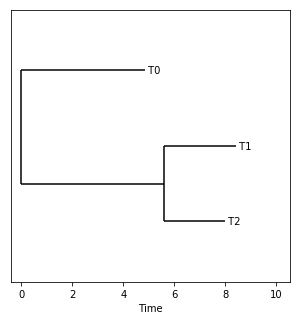

In [2]:
import Bio.Phylo
import io
import matplotlib.pyplot as plt


with open('3taxa/0/run_summary.yaml') as f:
    run_summary = yaml.load(f)
newick_string = run_summary['newick_string']
bio_tree = next(Bio.Phylo.parse(io.StringIO(newick_string), format='newick'))

fig, ax = plt.subplots(figsize=(5, 5))

Bio.Phylo.draw(bio_tree, axes=ax, do_show=False)
ax.set_xlabel('Time');
ax.get_yaxis().set_visible(False)

terminals = bio_tree.get_terminals()
depths = bio_tree.depths()
root_height = max(depths.values())
internal_clade = bio_tree.common_ancestor(terminals[:-1])

In [3]:
import sys
sys.path += ['..']
import topology_inference
import templating
build_templates = templating.TemplateBuilder('3taxa/0')

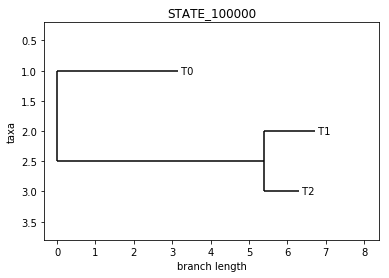

In [4]:
with open(build_templates.beast_analysis_tree_path) as f:
    beast_trees = list(Bio.Phylo.parse(f, format='nexus'))[int(config['chain_length']/config['log_every']*config['burn_in']):]
Bio.Phylo.draw(beast_trees[0])

In [5]:
import numpy as np

def get_tree_stats(mcmc_tree):
    depths = mcmc_tree.depths()
    root_height = max(depths.values())
    internal_node = mcmc_tree.common_ancestor('T1', 'T2')
    internal_node_height = root_height - depths[internal_node]
    return [internal_node_height, root_height]

tree_stats = np.array([get_tree_stats(mcmc_tree) for mcmc_tree in beast_trees])
beast_root_heights = tree_stats[:, 1]
beast_internal_node_heights = tree_stats[:, 0]

In [6]:
import pickle
with open(build_templates.pymc_analysis_result_path, 'rb') as f:
    approx = pickle.load(f)

In [7]:
lsd_tree = topology_inference.extract_lsd_tree(build_templates)
import io
newick_io = io.StringIO()
Bio.Phylo.write([lsd_tree], newick_io, format='newick')
lsd_newick = newick_io.getvalue()
lsd_newick

'(T0:5.07190,(T2:1.29085,T1:1.70915):6.92810):0.00000;\n'

In [8]:
import newick
import pylo.topology
import pylo.tree.transform

lsd_tree = newick.loads(lsd_newick)[0]
lsd_topology = pylo.topology.TreeTopology(lsd_tree)
lsd_transform = pylo.tree.transform.TreeHeightProportionTransform(lsd_topology)
tree_means = approx.groups[0].bij.rmap(approx.mean.eval())['tree_tree_height_proportion__']
tree_sds = approx.groups[0].bij.rmap(approx.std.eval())['tree_tree_height_proportion__']
tree_means

array([-1.53302986,  1.59853158])

In [9]:
import newick
import pylo.topology
import pylo.tree.transform
import numpy as np
from scipy.stats import multivariate_normal
import theano
import theano.tensor as tt

x_min = tree_means[0] - 3*tree_sds[0]
x_max = tree_means[0] + 3*tree_sds[0]
y_min = tree_means[1] - 3*tree_sds[1]
y_max = tree_means[1] + 3*tree_sds[1]

delta = 0.1
x_points = np.arange(x_min, x_max, delta)
y_points = np.arange(y_min, y_max, delta)
X, Y = np.meshgrid(x_points, y_points)
q_f = multivariate_normal(mean=tree_means, cov=np.diag(tree_sds ** 2))

x = X.flatten()
y = Y.flatten()
U = np.column_stack((x, y))

u_ = tt.vector()
t_ = lsd_transform.backward(u_)
jacobian_det_ = lsd_transform.jacobian_det(u_)

backward_func = theano.function([u_], t_)
jacobian_func = theano.function([u_], jacobian_det_)

T = np.row_stack([backward_func(u) for u in U])
jacobian_dets = np.array([jacobian_func(u) for u in U])

q_trans = q_f.pdf(U)

In [10]:
tree_stats_transformed = np.row_stack([lsd_transform.forward_val(row) for row in tree_stats])
tree_stats_transformed

array([[-1.80316469,  1.14579846],
       [-0.90649128,  1.72581342],
       [-1.25500498,  1.16970537],
       ...,
       [-0.71004293,  1.40388158],
       [-0.18374546,  1.02778491],
       [-2.99848711,  1.63879799]])

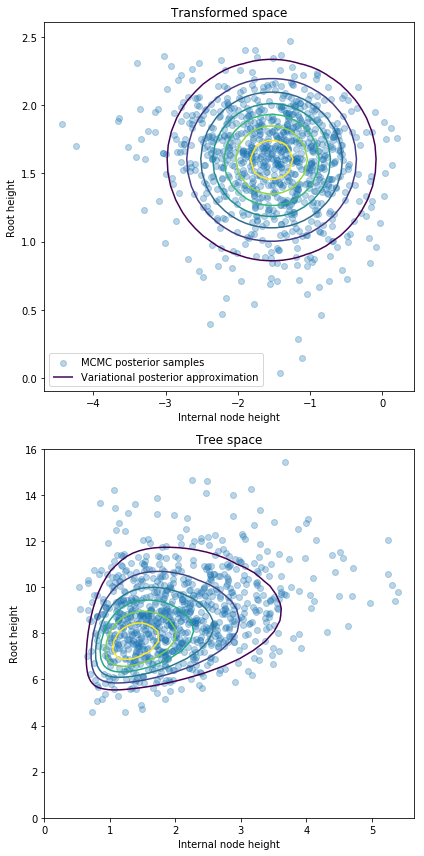

In [17]:
fig, axs = plt.subplots(figsize=(6, 12), nrows=2)

ax1 = axs[0]
ax1.set_title('Transformed space')
ax1.scatter(tree_stats_transformed[:, 0], tree_stats_transformed[:, 1], alpha=0.3, label='MCMC posterior samples')

xlim1 = ax1.get_xlim()
ylim1 = ax1.get_ylim()

cs = ax1.contour(X, Y, q_trans.reshape(X.shape))
cs.collections[0].set_label('Variational posterior approximation')

ax1.set_xlim(xlim1)
ax1.set_ylim(ylim1)
ax1.legend()

ax2 = axs[1]
ax2.set_title('Tree space')
ax2.scatter(beast_internal_node_heights, beast_root_heights, alpha=0.3, label='MCMC posterior samples')

xlim2 = ax2.get_xlim()
ylim2 = ax2.get_ylim()
ax2.contour(T[:, 0].reshape(X.shape), T[:, 1].reshape(X.shape), (q_trans / np.exp(jacobian_dets)).reshape(X.shape))

ax2.set_xlim((0,xlim2[1]))
ax2.set_ylim((0, ylim2[1]))

[ax.set_xlabel('Internal node height') for ax in axs]
[ax.set_ylabel('Root height') for ax in axs]

plt.tight_layout()
plt.savefig(str(out_dir / 'tree_posterior.png'))